# Performance on simulated protons and muons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from initializers import *

In [2]:
today = '20_02_02'

In [4]:
!mkdir -p /sbnd/app/users/gputnam/calorimetry-likelihood/proton_muon/
!mkdir -p /sbnd/app/users/gputnam/calorimetry-likelihood/proton_muon/pdfs/

In [4]:
save_folder = '/sbnd/app/users/gputnam/calorimetry-likelihood/proton_muon/'
save_folder_pdfs = save_folder + 'pdfs/'

In [5]:
branches = [
    'run',
    'sub',
    'evt',
    
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_process_is_stopping',
    'backtracked_end_in_tpc',
    
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'generation',
    'trk_daughters',
    'shr_daughters',

    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',
    
    'trk_pid_chipr_u',
    'trk_pid_chipr_v',
    'trk_pid_chipr_y',
    'trk_pid_chimu_y',
    'trk_bragg_p_y',
    'trk_bragg_mu_y',
    'trk_bragg_p_three_planes',

    'trk_len',
    'longest',
    
    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [6]:
file_bnb = '/pnfs/sbnd/scratch/users/gputnam/numu-selection/bnblike_single/caloout.root'

folder = "caloana"
tree = "CalorimetryAnalyzer"

split_factor = 0.9
split_factor2 = 0.1
root_file = uproot.open(file_bnb)[folder][tree]
entry_split = int(len(root_file) * split_factor)
entry_split2 = int(len(root_file) * split_factor2)
array_train = root_file.arrays(branches, namedecode="utf-8") #entrystop=entry_split)
array_test = root_file.arrays(branches, namedecode="utf-8") #entrystart=entry_split, entrystop=entry_split2)

In [7]:
for array in [array_train, array_test]:
    initialisation_for_caloriemtry_data_mc(array)

In [49]:
len(array_test['run'])

131282

In [50]:
def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.8) &\
           (array['backtracked_purity'] > 0.8) &\
           (array['end_is_fiducial']) &\
           (array['start_is_fiducial']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0) &\
           (array['non_inelastic'])

def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.8) &\
           (array['backtracked_purity'] > 0.8) &\
           (array['backtracked_end_in_tpc']) &\
           (array['backtracked_process_is_stopping']) &\
           (array['non_inelastic'])

def selection_for_test(array):
    return (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0)

def muon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==13)

def proton_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==2212)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [9]:
selection_train = selection_for_train(array_train)
selection_train_planes = selection_planes(array_train)
selection_test = selection_for_test(array_test)
selection_test_planes = selection_planes(array_test)

In [52]:
print(len([x for x in selection_train if x]))
print(len(array_train['run']))

43989
131282


In [53]:
# # calibration
# def scale_calibration(mu, dedx):
#     return dedx * mu[0]
# caloLikelihood_cali = caloLikelihood(None)
# caloLikelihood_cali.load(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration.dat')
# for array in [array_train, array_test]:
#     for plane_num, plane in enumerate(['u', 'v', 'y']):
#         array['dedx_{}_cali'.format(plane)] = caloLikelihood_cali.calibrateDedxExternal(array, plane_num)

In [ ]:
# parameters_names = ['rr', 'pitch']
# parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
#                   [.0, 0.6, 1, 1.5, 3, 30]]

# dedx_var = 'dedx'
# dedx_var_end = '_cali'
# dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

# parameters = []
# dedx_vars = []
# for plane in ['u', 'v', 'y']:
#     parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
#     dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)

# pdgcode_var = 'backtracked_pdg'

In [ ]:
# for array in [array_train, array_test]:
#     array['residual range'] = array['rr_y']
#     array['pitch'] = array['pitch_y']
    
# parameters_names = ['rr', 'pitch']
# parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
#                   [.0, 0.6, 1, 1.5, 3, 30]]

# dedx_var = 'dedx'
# dedx_var_end = '_cali'
# dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

# parameters = []
# dedx_vars = []
# for plane in ['u', 'v', 'y']:
#     if plane == 'y':
#         parameters.append(['residual range', 'pitch'])
#         dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)
#     else:
#         parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
#         dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)

# pdgcode_var = 'backtracked_pdg'

In [10]:
parameters_names = ['rr', 'pitch']
parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
                         [0.,30]]
                        # [.0, 0.6, 1, 1.5, 3, 30]]

dedx_var = 'dedx'
dedx_var_end = ''#'_cali'
dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)

pdgcode_var = 'backtracked_pdg'

In [11]:
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train, quality_masks_planes=selection_train_planes)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test, quality_masks_planes=selection_test_planes)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [12]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 13)    
    caloLike_train.buildLookUpTableMC(i, 2212)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [13, 2212])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:135: RuntimeWarning: invalid value encountered in true_divide
  hist_total/hist_partial[..., np.newaxis],
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:146: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:146: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),


In [13]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[13, 2212], cali=False)
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array, selection_test_planes, cali=False)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:251: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:298: RuntimeWarning: invalid value encountered in subtract
  array['log_like_ratio_{}'.format(plane)] = array['like_{}_sum_{}'.format(pdg_codes[0], plane)] - array['like_{}_sum_{}'.format(pdg_codes[1], plane)]
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:300: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:301: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']


In [28]:
caloLike_train.printCplusplusLookUp(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_proton_muon_lookup.h', planes=[0, 1, 2])

In [ ]:
caloLike_train.logLikelihoodRatioOneHit(2, 2.5, [27, 4])

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [ ]:
for plane_num in [2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=13, 
                                  parameters_value=bin_center, 
                                  label='muon')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=2212, 
                                  parameters_value=bin_center, 
                                  label='proton')
        plt.xlim(0, 20)
        plt.tight_layout()
        plt.savefig(save_folder_pdfs+'plane_{}_rr_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]))
        plt.close()

## 2d plots dedx vs rr

### for different values of the pitch

In [ ]:
# dedx vs rr
pitch_binning = [0.3, 0.6, 1, 1.5, 3, 30]
binning = [50, 50]
range = [[0, 40], [0, 20]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch'+plane] >= pitch_low) & (array['pitch'+plane] < pitch_high)
    
        for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
            pdg_mask = np.abs(array['backtracked_pdg'])==pdg
            total_mask = selection_train & selection_train_planes[i] & pitch_mask & pdg_mask
            
            dedx = array['dedx'+plane][total_mask].flatten()
            rr = array['rr'+plane][total_mask].flatten()
            
            plt.hist2d(rr, dedx, bins=binning, range=range)
            plt.title('MicroBooNE In Progress', loc='right')
            plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                      'fully contained, completeness, purity > 90%\n'+
                      'only hits with {:.2g} cm <= pitch < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                      '{} plane'.format(plane_label), loc='left')
            plt.xlabel('Residual range [cm]')
            plt.ylabel('dE/dx [MeV/cm]')
            plt.tight_layout()
            plt.savefig(save_folder+'dedx_rr_plane_{}_pdg_{}_{}_pitch_{}.png'.format(i, pdg, pitch_low, pitch_high), dpi=250)
            plt.close()

In [ ]:
# dedx given rr
pitch_binning = [0.3, 0.6, 1, 1.5, 3, 30]
binning = 50
range = [0, 20]
rr_bin = [10, 15]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch'+plane] >= pitch_low) & (array['pitch'+plane] <= pitch_high)
    
        for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
            pdg_mask = np.abs(array['backtracked_pdg'])==pdg
            rr_mask = (array['rr'+plane] > rr_bin[0]) & (array['rr'+plane] < rr_bin[1])
            total_mask = selection_train & selection_train_planes[i] & pitch_mask & pdg_mask & rr_mask
            
            dedx = array['dedx'+plane][total_mask].flatten()
            
            plt.hist(dedx, bins=binning, range=range, label=pdg_label, histtype='step')
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n'+
                  'only hits with {:.2g} cm <= pitch < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                  'only hits with {:.2g} cm <= rr < {:.2g} cm\n'.format(rr_bin[0], rr_bin[1])+
                  '{} plane'.format(plane_label), loc='left')
        plt.ylabel('Number of entries')
        plt.xlabel('dE/dx [MeV/cm]')
        plt.tight_layout()
        plt.legend()
        plt.savefig(save_folder+'dedx_plane_{}_{}_pitch_{}.png'.format(i, pitch_low, pitch_high), dpi=250)
        plt.close()

In [ ]:
# distribution of direction of particles

binning = [21, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
    pdg_mask = np.abs(array['backtracked_pdg'])==pdg
    total_mask = selection_train & pdg_mask
    costheta = np.cos(array['trk_theta'])[total_mask]
    phi = array['trk_phi'][total_mask]
    
    plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
    plt.title('MicroBooNE In Progress', loc='right')
    plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
              'fully contained, completeness, purity > 90%\n', loc='left')
    plt.xlabel(r'track $\cos \theta$')
    plt.ylabel(r'track $\phi$')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(save_folder+'cos_theta_phi_pdg_{}_train.png'.format(pdg), dpi=250)
    plt.close()
    
    total_mask = selection_for_test(array) & pdg_mask
    costheta = np.cos(array['trk_theta'])[total_mask]
    phi = array['trk_phi'][total_mask]
    
    plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
    plt.title('MicroBooNE In Progress', loc='right')
    plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
              'fully contained\n', loc='left')
    plt.xlabel(r'track $\cos \theta$')
    plt.ylabel(r'track $\phi$')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(save_folder+'cos_theta_phi_pdg_{}_test.png'.format(pdg), dpi=250)
    plt.close()

In [ ]:
# angular distribution of hits

binning = [21, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()

        plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit $\phi$')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'hit_cos_theta_phi_plane_{}_pdg_{}_train.png'.format(plane, pdg), dpi=250)
        plt.close()

        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()

        plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit $\phi$')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'hit_cos_theta_phi_plane_{}_pdg_{}_test.png'.format(i, pdg), dpi=250)
        plt.close()

In [ ]:
# relationship between pitch and costheta

binning = [51, 101]
range = [[-1, 1], [0, 5]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        pitch = array['pitch'+plane][total_mask].flatten()

        plt.hist2d(costheta, pitch, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit pitch')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'hit_cos_theta_pitch_plane_{}_pdg_{}_train.png'.format(plane, pdg), dpi=250)
        plt.close()

        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        pitch = array['pitch'+plane][total_mask].flatten()

        plt.hist2d(costheta, pitch, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit pitch')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'hit_cos_theta_pitch_plane_{}_pdg_{}_test.png'.format(i, pdg), dpi=250)
        plt.close()

In [ ]:
# fraction of hits with bad dE/dx

binning = [51, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()
        dedx = array['dedx'+plane][total_mask].flatten()
        
        def fraction_of_bad_hits(dedx):
            return ((dedx > 0) & (dedx < 1)).sum() / (dedx > 0).sum()
        ret = binned_statistic_2d(costheta, phi, dedx, statistic=fraction_of_bad_hits, bins=binning, range=range, expand_binnumbers=False)
        plt.pcolormesh(ret.x_edge, ret.y_edge, ret.statistic.T)
        
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Fraction of hits with dE/dx < 1 MeV/cm\nSimulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$ wrt to wires')
        plt.ylabel(r'hit $\phi$ wrt to wires')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'bad_hit_fraction_cos_theta_phi_plane_{}_pdg_{}_train.png'.format(plane, pdg), dpi=250)
        plt.close()

        
        
        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()
        dedx = array['dedx'+plane][total_mask].flatten()
        
        def fraction_of_bad_hits(dedx):
            return ((dedx > 0) & (dedx < 1)).sum() / (dedx > 0).sum()
        ret = binned_statistic_2d(costheta, phi, dedx, statistic=fraction_of_bad_hits, bins=binning, range=range, expand_binnumbers=False)
        plt.pcolormesh(ret.x_edge, ret.y_edge, ret.statistic.T)
        
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Fraction of hits with dE/dx < 1 MeV/cm\nSimulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$ wrt to wires')
        plt.ylabel(r'hit $\phi$ wrt to wires')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(save_folder+'bad_hit_fraction_cos_theta_phi_plane_{}_pdg_{}_test.png'.format(plane, pdg), dpi=250)
        plt.close()

## Plots

In [14]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [15]:
interesting_variables = ['trk_pid_chipr_y',
                         'trk_pid_chimu_y',
                         'trk_bragg_p_y',
                         'trk_bragg_mu_y',
                         'trk_bragg_p_three_planes',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

# variable_labels = {
#     'trk_pid_chipr_y': '$\chi^2_{proton}$ Y',
#     'trk_pid_chimu_y': '$\chi^2_{\mu}$ Y',
#     'trk_bragg_p_y': 'Bragg likelihood Y',
#     'trk_bragg_mu_y': 'Bragg likelihood muon Y',
#     'trk_bragg_p_three_planes': 'Bragg likelihood UVY',
#     'llr_sum_0': 'LLR U',
#     'llr_sum_1': 'LLR V',
#     'llr_sum_2': 'LLR Y',
#     'llr_01': 'LLR UV',   
#     'llr_012': 'LLR UVY',   
# }

variable_labels = {
    'trk_pid_chipr_y': '$\chi^2_{proton}$ collection plane',
    'trk_pid_chimu_y': '$\chi^2_{\mu}$ collection plane',
    'trk_bragg_p_y': 'Bragg likelihood collection plane',
    'trk_bragg_mu_y': 'Bragg likelihood muon collection plane',
    'trk_bragg_p_three_planes': 'Bragg likelihood all planes',
    'llr_sum_0': 'LogLikelihoodRatio (this work) first induction plane',
    'llr_sum_1': 'LogLikelihoodRatio (this work) second induction plane',
    'llr_sum_2': 'LogLikelihoodRatio (this work) collection plane',
    'llr_01': 'LogLikelihoodRatio (this work) first and second induction plane',   
    'llr_012': 'LogLikelihoodRatio (this work) all planes',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 100
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 10
    add_norm_variable(caloLike_test.array, variable, scale)

In [16]:
bins = 41
range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', **kwargs);
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, range, function_mask=cosmic_for_test, quality_mask=True, label='cosmic', **kwargs);
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
    plt.savefig(save_folder + variable + '.png', dpi=250)
    plt.close()

## ROC curves

In [18]:
caloLike_test.array['trk_pid_chipr_y']

array([-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
       -3.4028235e+38, -3.4028235e+38, -3.4028235e+38], dtype=float32)

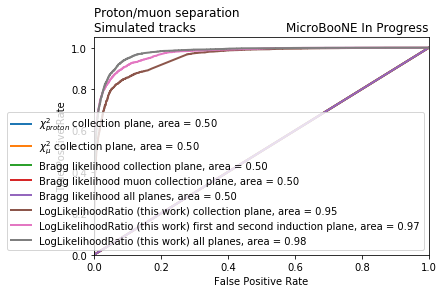

In [17]:
for variable in interesting_variables:
    caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[13, 2212], 
         plot=True,
         variable_label=variable_labels[variable])

plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.savefig(save_folder + 'roc_curves.pdf', dpi=100,figsize=(10,10))

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
                         'llr_01',
                         'llr_sum_2',
                         'llr_012',
                        ]
parameter_name = 'trk_theta'
parameter_bin_edges = np.linspace(0, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\theta$')
plt.legend()
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.savefig(save_folder+'auc1d'+parameter_name+'.pdf', dpi=250)
plt.close()

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
#                          'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
#                          'llr_01',
#                          'llr_sum_2',
#                          'llr_012',
                        ]
parameter_name = 'trk_phi'
parameter_bin_edges = np.linspace(-np.pi, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\phi$')
plt.legend(frameon=False)
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.ylim(0.35, 1)
plt.savefig(save_folder+'auc1d_only_collection'+parameter_name+'.pdf')
plt.close()

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
#                          'llr_01',
#                          'llr_sum_2',
#                          'llr_012',
                        ]
parameter_name = 'trk_phi'
parameter_bin_edges = np.linspace(-np.pi, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\phi$')
plt.legend(frameon=False)
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.ylim(0.35, 1)
plt.savefig(save_folder+'auc1d'+parameter_name+'.pdf')
plt.close()

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = ['trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
#                          'llr_01',
                         'llr_sum_2',
                         'llr_012',
                        ]
parameter_name = 'trk_phi'
parameter_bin_edges = np.linspace(-np.pi, np.pi, 20)

for variable in interesting_variables:
    caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
    
plt.xlabel(r'Track $\phi$')
plt.legend(frameon=False)
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.ylim(0.35, 1)
plt.savefig(save_folder+'auc1d'+parameter_name+'.pdf')
plt.close()

In [ ]:
def selection_function(array, parameters_names, bin_ranges):
    return (array[parameters_names[0]] >= bin_ranges[0][0]) &\
           (array[parameters_names[0]] < bin_ranges[0][1]) &\
           (array[parameters_names[1]] >= bin_ranges[1][0]) &\
           (array[parameters_names[1]] < bin_ranges[1][1])

pdg_codes = [13, 2212]

parameters_names = ['trk_theta', 'trk_phi']
parameter_bin_edges = (np.linspace(0, np.pi, 6), np.linspace(-np.pi, np.pi, 10))

for variable in interesting_variables:
    caloLike_test.auc2D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            parameters_names, 
                            parameter_bin_edges)

    plt.xlabel(r'Track $\theta$')
    plt.ylabel(r'Track $\phi$')
    plt.title('Proton/muon separation\nSimulated tracks\nArea Under the Roc Curve\n'+variable_labels[variable]+'\n', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder+'auc2d'+variable+'.png', dpi=250)
    plt.close()

# Load data to do some plots with it

In [ ]:
file_data_on = '~/Desktop/MicroBooNE/calorimetry_likelihood/v05/beam_on/out.root'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

stop_factor = 0.1
root_file = uproot.open(file_bnb)[folder][tree]
entry_stop = int(len(root_file) * stop_factor)
array_data = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_stop)

In [ ]:
initialisation_for_caloriemtry_data_mc(array_data)
selection_data_planes = selection_planes(array_data)
selection_data_test = selection_for_test(array_data)
# caloLike_train.addCalorimetryVariables(array_data, pdg_codes=[13, 2212], cali=False)
caloLike_train.addCalorimetryVariablesFromLLRTable(array_data, selection_data_planes, cali=False)
add_norm_variable(array_data, 'llr_012', scale=100)

In [ ]:
trk_score_selection = (array_data['trk_score'] > 0.8)
llr_pid_data = array_data['llr_012_n'][selection_data_test & trk_score_selection]

In [ ]:
plt.hist(llr_pid_data, bins=101, range=[-1, 1])
plt.xlabel('LLR PID')
plt.ylabel('Number of Entries')
plt.title('Data Beam ON, fully contained tracks')

In [ ]:
# dedx vs rr
pitch_binning = [0.3, 1, 1.5, 30]
binning = [50, 50]
range = [[0, 40], [0, 20]]
array = array_data
trk_score_selection = (array['trk_score'] > 0.8)
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch'+plane] >= pitch_low) & (array['pitch'+plane] < pitch_high)
    
        for llr_lim, pdg_label in zip([[-1, -0.5], [0.5, 1]], ['proton', 'muon']):
            llr_mask = (array['llr_012_n'] >= llr_lim[0]) & (array['llr_012_n'] < llr_lim[1])
            total_mask = selection_data_test & selection_data_planes[i] & trk_score_selection & pitch_mask & llr_mask
            
            dedx = array['dedx'+plane][total_mask].flatten()
            rr = array['rr'+plane][total_mask].flatten()
            
            plt.hist2d(rr, dedx, bins=binning, range=range)
            plt.title('MicroBooNE In Progress', loc='right')
            plt.title('Reconstructed tracks in data Beam ON\n'.format(pdg_label)+
                      'fully contained, track score > 0.8\n'+
                      '{} candidate with {:.2g} < pid < {:.2g}\n'.format(pdg_label, llr_lim[0], llr_lim[1])+
                      'only hits with {:.2g} cm <= pitch < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                      '{} plane'.format(plane_label), loc='left')
            plt.xlabel('Residual range [cm]')
            plt.ylabel('dE/dx [MeV/cm]')
            plt.tight_layout()
            plt.savefig(save_folder+'data_dedx_rr_plane_{}_{}_pitch_{}.png'.format(i, pdg_label, pitch_low, pitch_high), dpi=250)
            plt.close()

In [ ]:
# dedx vs rr
global_pitch_binning = [0.3, 1, 1.5, 30]
binning = [50, 50]
range = [[0, 40], [0, 20]]
array = array_data
trk_score_selection = (array['trk_score'] > 0.8)
array['global_pitch_y'] = 0.3/np.cos(array['trk_theta'])
for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
    pitch_mask = (array['global_pitch_y'] >= pitch_low) & (array['global_pitch_y'] < pitch_high)
    
    for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
        for llr_lim, pdg_label in zip([[-1, -0.5], [0.5, 1]], ['proton', 'muon']):
            llr_mask = (array['llr_012_n'] >= llr_lim[0]) & (array['llr_012_n'] < llr_lim[1])
            total_mask = selection_data_test & selection_data_planes[i] & trk_score_selection & pitch_mask & llr_mask
            
            dedx = array['dedx'+plane][total_mask].flatten()
            rr = array['rr'+plane][total_mask].flatten()
            
            plt.hist2d(rr, dedx, bins=binning, range=range)
            plt.title('MicroBooNE In Progress', loc='right')
            plt.title('Reconstructed tracks in data Beam ON\n'.format(pdg_label)+
                      'fully contained, track score > 0.8\n'+
                      '{} candidate with {:.2g} < pid < {:.2g}\n'.format(pdg_label, llr_lim[0], llr_lim[1])+
                      'only tracks with {:.2g} cm <= track pitch Y < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                      '{} plane'.format(plane_label), loc='left')
            plt.xlabel('Residual range [cm]')
            plt.ylabel('dE/dx [MeV/cm]')
            plt.tight_layout()
            plt.savefig(save_folder+'data_dedx_rr_plane_{}_{}_trk_pitchy_{}.png'.format(i, pdg_label, pitch_low, pitch_high), dpi=250)
            plt.close()